In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import malaya_speech
from malaya_speech import Pipeline
from malaya_speech.utils.astype import float_to_int

`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


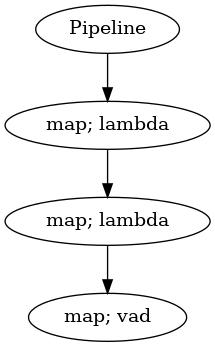

In [3]:
vad_model = malaya_speech.vad.webrtc()
p_vad = Pipeline()
pipeline = (
    p_vad.map(lambda x: malaya_speech.resample(x, old_samplerate = 22050, new_samplerate = 16000))
    .map(lambda x: float_to_int(x, divide_max_abs=False))
    .map(vad_model)
)
p_vad.visualize()

In [4]:
model = malaya_speech.stt.transducer.pt_transformer(model = 'mesolitica/conformer-medium',
                                                   local_files_only=True)

In [5]:
_ = model.cuda()
_ = model.eval()

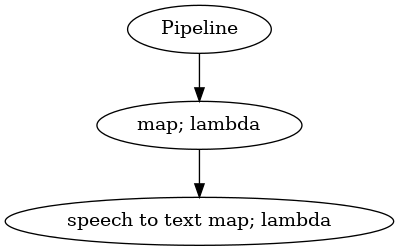

In [6]:
p_asr = Pipeline()
pipeline_asr = (
    p_asr.map(lambda x: malaya_speech.resample(x, old_samplerate = 22050, new_samplerate = 16000))
    .map(lambda x: model.beam_decoder([x])[0], name = 'speech-to-text')
)
p_asr.visualize()

In [7]:
speaker_v = malaya_speech.speaker_vector.nemo(model = 'huseinzol05/nemo-titanet_large', 
                                              local_files_only=True)

_ = speaker_v.cuda()
_ = speaker_v.eval()

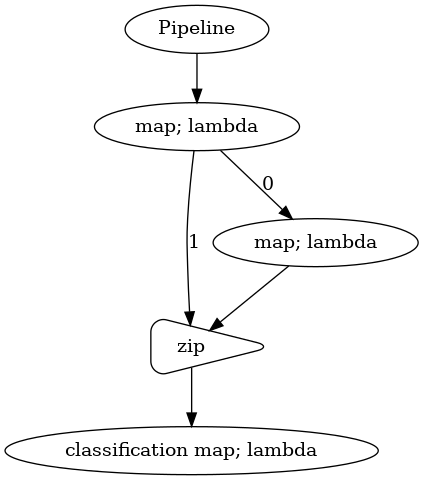

In [8]:
speakers = {}

p_classification = Pipeline()
to_float = p_classification
vector = to_float.map(lambda x: speaker_v([x])[0])
speaker = vector.map(lambda x: streaming_speaker_similarity(x, speakers = speakers, similarity_threshold = 0.7))
vector.zip(speaker).map(lambda x: x, name = 'classification')

p_classification.visualize()

In [9]:
from malaya_speech.diarization import streaming_speaker_similarity
import numpy as np

In [10]:
speaker_overlap = malaya_speech.speaker_overlap.deep_model(model = 'vggvox-v2',
                                                          local_files_only=True,
                                                          device = 'gpu:0')

2023-02-23 15:38:34.235796: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 15:38:34.237040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 15:38:34.249013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 15:38:34.249723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [11]:
is_clean = malaya_speech.is_clean.nemo(model = 'huseinzol05/nemo-is-clean-speakernet')
_ = is_clean.cuda()
_ = is_clean.eval()

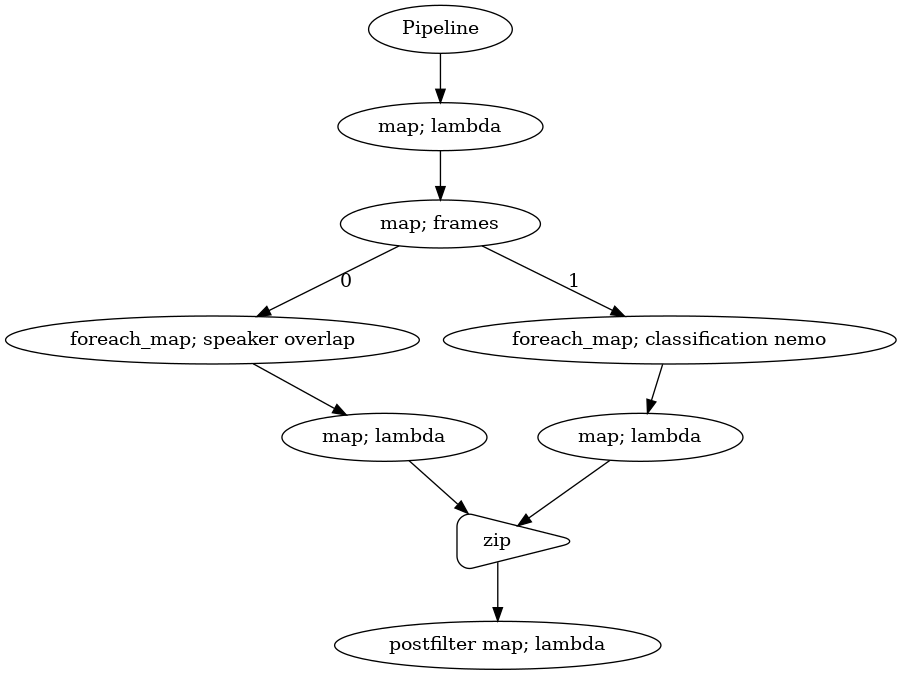

In [12]:
p_postfilter = Pipeline()
p_frames = p_postfilter.map(lambda x: malaya_speech.resample(x, old_samplerate = 22050, new_samplerate = 16000)) \
.map(malaya_speech.utils.generator.frames, frame_duration_ms = 100, 
                     append_ending_trail = False)
p_speaker_overlap = p_frames.foreach_map(speaker_overlap) \
.map(lambda x: np.mean(x) <= 0.1)
is_clean_overlap = p_frames.foreach_map(is_clean) \
.map(lambda x: np.mean(x) >= 0.1)
p_speaker_overlap.zip(is_clean_overlap).map(lambda x: np.mean(x) == 1, name = 'postfilter')
p_postfilter.visualize()

In [13]:
from glob import glob

youtubes = sorted(glob('/home/husein/ssd2/youtube/audio/*.mp3'))
len(youtubes)

6081

In [14]:
from unidecode import unidecode
import torchaudio
import torch
import pickle

In [15]:
parent_dir = '/home/husein/ssd2/processed-youtube'
# !rm -rf {parent_dir}
!mkdir {parent_dir}

mkdir: cannot create directory ‘/home/husein/ssd2/processed-youtube’: File exists


In [16]:
parent_dir_done = '/home/husein/ssd2/processed-youtube-done'
# !rm -rf {parent_dir_done}
!mkdir {parent_dir_done}

mkdir: cannot create directory ‘/home/husein/ssd2/processed-youtube-done’: File exists


In [17]:
from tqdm import tqdm

In [18]:
for f in tqdm(youtubes):
    
    new_f = unidecode(os.path.split(f)[1].replace('.mp3', '').replace(' ', '_'))
    f_done = os.path.join(parent_dir_done, new_f)
    
    if os.path.exists(f_done):
        continue
    
    speakers = {}
    samples = malaya_speech.streaming.torchaudio.stream(f,
                                                        vad_model = p_vad, 
                                                        asr_model = p_asr,
                                                        classification_model = p_classification,
                                                        postfilter_model = p_postfilter,
                                                        segment_length = 441,
                                                        realtime_print = False,
                                                        sample_rate = 22050)
    
    if len(samples):
        
        parent_new_f = os.path.join(parent_dir, new_f)
        os.makedirs(parent_new_f, exist_ok=True)

        for i in range(len(samples)):
            audio_path = os.path.join(parent_new_f, f'{i}.mp3')
            torchaudio.save(audio_path, 
                            torch.tensor(samples[i]['wav_data'].astype('float32')).unsqueeze(0), 
                            22050, format='mp3')
            samples[i]['wav_data'] = audio_path

        with open(f'{parent_new_f}.pkl', 'wb') as fopen:
            pickle.dump(samples, fopen)
            
    with open(f_done, 'w') as fopen:
        fopen.write('done')

  0%|                                                  | 0/6081 [00:00<?, ?it/s]2023-02-23 15:38:45.828322: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302
2023-02-23 15:38:47.059435: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-23 15:38:47.294614: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|█████████████████████████████████████| 6081/6081 [7:16:36<00:00,  4.31s/it]
